In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = ""
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In [2]:
# Analytically study the behaviour of Monte Carlo dropout
# https://arxiv.org/pdf/2008.02627.pdf

mean_values_prediction = np.random.uniform(-10, 10, 1000)
K = 10
pd = 0.8

expected_mean_value = K * (1 - pd) * mean_values_prediction / (K * (1 - pd) + pd) 
expected_variance = K * pd * (1 - pd) * mean_values_prediction**2 / (K * (1 - pd) + pd)**2

# plot the results
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(mean_values_prediction, expected_mean_value, 'o')
ax[0].plot(mean_values_prediction, mean_values_prediction, 'r')
ax[0].set_xlabel('Mean value of prediction')
ax[0].set_ylabel('Expected mean value')

ax[1].plot(mean_values_prediction, expected_variance, 'o')
ax[1].set_xlabel('Mean value of prediction')
ax[1].set_ylabel('Expected variance')




Text(0, 0.5, 'Expected variance')

<Figure size 720x360 with 0 Axes>

In [3]:
# Experimentally study the behaviour of Monte Carlo dropout

# generate data
X_train = np.random.uniform(-10, 10, 10000)
Y_train = X_train * 2 + 5
X_test = np.random.uniform(-10, 10, 50)
Y_test = X_test * 2 + 5

# define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(K, input_shape=(1,)),
    tf.keras.layers.Dropout(pd),
    tf.keras.layers.Dense(1),
])

# compile the model
model.compile(optimizer='adam', loss='mse')
print("Compiled model")
# train the model
history = model.fit(X_train, Y_train, epochs=100, verbose=0)
print("Trained model")
# make predictions using monte carlo dropout
num_monte_carlo = 100
print("Making predictions")
predictions = []
for xtest in X_test:
    predictions.append([model(xtest.reshape(1, -1), training=True) for _ in range(num_monte_carlo)])


Compiled model
Trained model
Making predictions


Text(0, 0.5, 'variance')

<Figure size 720x360 with 0 Axes>

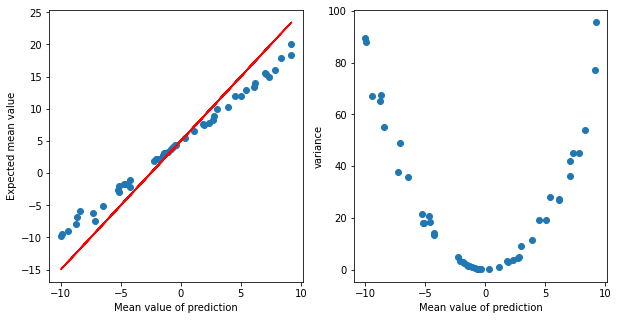

In [4]:
# Get the mean and variance of the predictions
predictions = np.array(predictions)
mean_predictions = np.mean(predictions, axis=1)
variance_predictions = np.var(predictions, axis=1)

# plot the results
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(X_test, mean_predictions.squeeze(), 'o')
ax[0].plot(X_test, X_test * 2 + 5, 'r')
ax[0].set_xlabel('Mean value of prediction')
ax[0].set_ylabel('Expected mean value')

ax[1].plot(X_test, variance_predictions.squeeze(), 'o')
ax[1].set_xlabel('Mean value of prediction')
ax[1].set_ylabel('variance')



In [12]:
def find_variance_of_network(n=1e3, epochs=100, K=10, pd=0.8):
    # Experimentally study the behaviour of Monte Carlo dropout
    import numpy as np 
    import os 
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    import tensorflow as tf
    # set the seed
    np.random.seed(0)
    tf.random.set_seed(0)
    n = int(n)
    # generate data
    X_train = np.random.uniform(-10, 10, n)
    Y_train = X_train * 2 + 5
    X_test = np.random.uniform(-10, 10, 50)
    Y_test = X_test * 2 + 5

    # define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(K, input_shape=(1,)),
        tf.keras.layers.Dropout(pd),
        tf.keras.layers.Dense(1),
    ])

    # compile the model
    model.compile(optimizer='adam', loss='mse')
    # train the model
    history = model.fit(X_train, Y_train, epochs=epochs, verbose=0)
    # make predictions using monte carlo dropout
    num_monte_carlo = 100
    predictions = []
    for xtest in X_test:
        predictions.append([model(xtest.reshape(1, -1), training=True) for _ in range(num_monte_carlo)])
    
    predictions = np.array(predictions)
    mean_predictions = np.mean(predictions, axis=1)
    variance_predictions = np.var(predictions, axis=1)

    del model
    return mean_predictions, variance_predictions

In [ ]:
from tqdm import tqdm
# study effect of n on variance
n_values = [10, 1e2, 1e3, 1e4, 1e5]

mean_predictions = []
variance_predictions = []

for n in tqdm(n_values):
    mean, variance = find_variance_of_network(n)
    mean_predictions.append(mean)
    variance_predictions.append(variance)


100%|██████████| 5/5 [05:33<00:00, 66.62s/it] 


Text(0, 0.5, 'Mean of predictions')

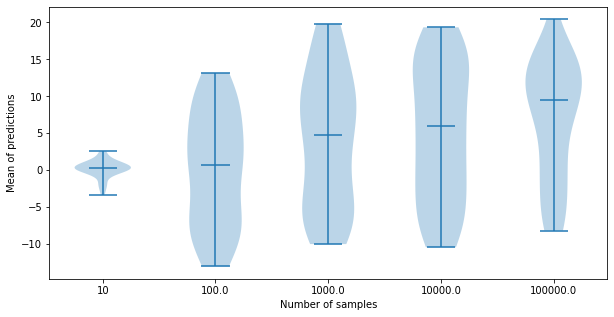

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
variance_predictions_plot = [x.squeeze() for x in variance_predictions]
# plot the results as a violin plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.violinplot(variance_predictions_plot, showmeans=False, showmedians=True, showextrema=True)
ax.set_xticks(range(1, len(n_values) + 1))
ax.set_xticklabels(n_values)
ax.set_xlabel('Number of samples')
ax.set_ylabel('Variance of predictions')

mean_predictions_plot = [x.squeeze() for x in mean_predictions]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.violinplot(mean_predictions_plot, showmeans=False, showmedians=True, showextrema=True)
ax.set_xticks(range(1, len(n_values) + 1))
ax.set_xticklabels(n_values)
ax.set_xlabel('Number of samples')
ax.set_ylabel('Mean of predictions')


In [17]:
epoch_list = [1, 2, 5, 10, 50, 100, 200, 500]
epoch_mean_predictions = []
epoch_variance_predictions = []

for epoch in tqdm(epoch_list):
    mean, variance = find_variance_of_network(1000, epochs=epoch)
    epoch_mean_predictions.append(mean)
    epoch_variance_predictions.append(variance)


# plot variance as a function of epochs
epoch_variance_predictions_plot = [x.squeeze() for x in epoch_variance_predictions]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.violinplot(epoch_variance_predictions_plot, showmeans=False, showmedians=True, showextrema=True)
ax.set_xticks(range(1, len(epoch_list) + 1))
ax.set_xticklabels(epoch_list)
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Variance of predictions')




100%|██████████| 8/8 [01:09<00:00,  8.72s/it]


Text(0, 0.5, 'Variance of predictions')